<a href="https://colab.research.google.com/github/BlackeWhite/SSD_Modanet/blob/master/FFSSD/FFSSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Google Drive File

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#pesi VGG_ILSVRC_16_layers_fc_reduced
Weight = drive.CreateFile({'id': '1sBmajn6vOE7qJ8GnxUJt4fGPuffVUZox'}) 
Weight.GetContentFile(Weight['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(Weight['title'], Weight['id']))

Modadat = drive.CreateFile({'id': '1il_eW1COHs1_QijMh3zklvhmE_Dfk0qh'}) 
Modadat.GetContentFile(Modadat['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(Modadat['title'], Modadat['id']))
!unzip dataset.zip

annotaz = drive.CreateFile({'id': '1aD4BgDD7grEFYlDKr0k_SHPw1qbt9N1q'}) 
annotaz.GetContentFile(annotaz['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(annotaz['title'], annotaz['id']))
!unzip annotazioni.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import library

Import library from github of Pireluigi Ferrari that had created the code for implement the SSD

In [ ]:
!pip install keras==2.2.3
!pip install tensorflow-gpu==1.15

import h5py
import numpy as np
import shutil
import os.path
if not(os.path.isdir('keras_layers')):
  !git clone https://github.com/pierluigiferrari/ssd_keras.git
  !mv ./ssd_keras/* . #copy all file in the root directory, you must this because after invocate the lib in the repository 
  !rm -r ssd_keras

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

import tensorflow as tf

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

# Set the model configuration parameters

In [ ]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR
n_classes = 13
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_coco
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; 
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

# Build the model or load the model

The code here has been adapted starting from the code on the [tanakataiki git ](https://github.com/tanakataiki/ssd_kerasV2.git)

In [ ]:
"""Keras implementation of FSSD."""
from __future__ import division
import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate,Deconvolution2D, add
from keras.regularizers import l2
import keras.backend as K

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast


def FSSD(image_size,
            n_classes,
            mode='training',
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,
            clip_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=[2, 1, 0],
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):
    """SSD300 architecture.
    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.
    # References
        https://arxiv.org/abs/1512.02325
    """

    n_predictor_layers = 6 # The number of predictor conv layers in the network is 6 for the original SSD300.
    n_classes += 1 # Account for the background class.
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Get a few exceptions out of the way.
    ############################################################################

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4:
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Compute the anchor box parameters.
    ############################################################################

    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Define functions for the Lambda layers below.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Build the network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))

    # The following identity layer is only needed so that the subsequent lambda layers can be optional.
    x1 = Lambda(identity_layer, output_shape=(img_height, img_width, img_channels), name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization, output_shape=(img_height, img_width, img_channels), name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization, output_shape=(img_height, img_width, img_channels), name='input_stddev_normalization')(x1)
    if swap_channels:
        x1 = Lambda(input_channel_swap, output_shape=(img_height, img_width, img_channels), name='input_channel_swap')(x1)

    # Block 1
    conv1_1 = Conv2D(64, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv1_1')(x1)
    conv1_2 = Conv2D(64, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool1')(conv1_2)
    # Block 2
    conv2_1 = Conv2D(128, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv2_1')(pool1)
    conv2_2 = Conv2D(128, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool2')(conv2_2)
    # Block 3
    conv3_1 = Conv2D(256, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv3_1')(pool2)
    conv3_2 = Conv2D(256, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool3')(conv3_3)
    # Block 4
    conv4_1 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv4_1')(pool3)
    conv4_2 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), padding='same',name='pool4')(conv4_3)
    # Block 5
    conv5_1 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv5_1')(pool4)
    conv5_2 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3),activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D((3, 3), strides=(1, 1), padding='same',name='pool5')(conv5_3)
    # FC6
    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='fc6')(pool5)
    #fc6 = Dropout(0.5, name='drop6')(fc6)
    # FC7
    fc7 = Conv2D(1024, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='fc7')(fc6)
    #fc7 = Dropout(0.5, name='drop7')(fc7)
    # Block 6
    conv6_1 = Conv2D(256, (1, 1), activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv6_1')(fc7)
    conv6_2 = Conv2D(512, (3, 3), strides=(2, 2),activation='relu', padding='same',name='conv6_2')(conv6_1)
    # Block 7
    conv7_1 = Conv2D(128, (1, 1), activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv7_1')(conv6_2)
    conv7_2 = ZeroPadding2D()(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), strides=(2, 2),activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv7_2')(conv7_2)
    # Block 8
    conv8_1 = Conv2D(128, (1, 1), activation='relu',padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv8_1')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), strides=(2, 2),activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv8_2')(conv8_1)
    # Last Pool
    conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
    pool6 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='pool6')(conv9_1)
    
    # Prediction from conv4_3
    conv4=Conv2D(512,(3,3),padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg),name='conv4')(conv4_3)
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4)
    deconv5_3 = Deconvolution2D(512, (3, 3),strides=(2, 2),padding='same',name='deconv5_3')(conv5_3)
    conv_deconv5_3=Conv2D(512, (3, 3),padding='same',name='conv_deconv5_3')(deconv5_3)
    conv5_3_norm = L2Normalization(gamma_init=20,name='conv_5_3_norm')(conv_deconv5_3)
    EltSUM=add([conv4_3_norm,conv5_3_norm])
    fusion_conv4_5=Activation(name='fusion_conv4_5',activation='relu')(EltSUM)
    
    ### Build the convolutional predictor layers on top of the base network

    # We precidt `n_classes` confidence values for each box, hence the confidence predictors have depth `n_boxes * n_classes`
    # Output shape of the confidence layers: `(batch, height, width, n_boxes * n_classes)`
    conv4_5_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_5_norm_mbox_conf')(fusion_conv4_5)
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
    pool6_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='pool6_mbox_conf')(pool6)
    # We predict 4 box coordinates for each box, hence the localization predictors have depth `n_boxes * 4`
    # Output shape of the localization layers: `(batch, height, width, n_boxes * 4)`
    conv4_5_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_5_norm_mbox_loc')(fusion_conv4_5)
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    pool6_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='pool6_mbox_loc')(pool6)
    
    #Generate priors conv4_5_norm_mbox_priorbox
    conv4_5_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], clip_boxes=clip_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_5_norm_mbox_priorbox')(conv4_5_norm_mbox_loc)
    #Generate priors fc7
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], clip_boxes=clip_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    #Generate priors conv6_2
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    #Generate priors conv7_2
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3], 
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], clip_boxes=clip_boxes, 
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    #Generate priors conv8_2
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    pool6_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='pool6_mbox_priorbox')(pool6_mbox_loc)
    
       ### Reshape

    # Reshape the class predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, n_classes)`
    # We want the classes isolated in the last axis to perform softmax on them
    conv4_5_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_5_norm_mbox_conf_reshape')(conv4_5_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    pool6_mbox_conf_reshape = Reshape((-1, n_classes), name='pool6_mbox_conf_reshape')(pool6_mbox_conf)
    # Reshape the box predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    conv4_5_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_5_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    pool6_mbox_loc_reshape = Reshape((-1, 4), name='pool6_mbox_loc_reshape')(pool6_mbox_loc)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    conv4_5_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_5_norm_mbox_priorbox_reshape')(conv4_5_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    pool6_mbox_priorbox_reshape = Reshape((-1, 8), name='pool6_mbox_priorbox_reshape')(pool6_mbox_priorbox)
    
    # Gather all predictions
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_5_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       pool6_mbox_conf_reshape])
    
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_5_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     pool6_mbox_loc_reshape])
    
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_5_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               pool6_mbox_priorbox_reshape])
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])
    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=normalize_coords,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))

    if return_predictor_sizes:
        predictor_sizes = np.array([conv4_5_norm_mbox_conf._keras_shape[1:3],
                                     fc7_mbox_conf._keras_shape[1:3],
                                     conv6_2_mbox_conf._keras_shape[1:3],
                                     conv7_2_mbox_conf._keras_shape[1:3],
                                     conv8_2_mbox_conf._keras_shape[1:3],
                                     pool6_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model

Create a new model and load trained VGG-16 weights into it

In [ ]:
K.clear_session() # Clear previous models from memory.

model, predictor_sizes = FSSD(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels,
                return_predictor_sizes=True)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = '/content/drive/My Drive/pesi_FFSSD/FFSSD_modanet_epoch-101_loss-6.0969_val_loss-6.4695.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss, metrics=['acc'])

# Load dataset

In [ ]:
def rename(path):
	lis = os.listdir(path)
	for item in lis:
		temp=item.split(".")
		while len(temp[0])<7:
			new=str(0)+temp[0]
			temp[0]=new
			if len(temp[0])==7:
				os.rename(path+item,path+temp[0]+".jpg")

In [ ]:
rename('./new_train/')
rename('./new_val/')
rename('./new_test/')

In [ ]:
# TODO: Set the paths to your dataset here.
train_images_path = ['./new_train/']
train_labels_path = ['annotazioni_train.json']
val_images_path= ['./new_val/']
val_labels_path = ['annotazioni_val.json']

train_dataset = DataGenerator(load_images_into_memory=False)
val_dataset = DataGenerator(load_images_into_memory=False)

train_dataset.parse_json(images_dirs=train_images_path,
                  annotations_filenames=train_labels_path,
                  ground_truth_available= True,
                  include_classes = 'all',
                  ret=True)

val_dataset.parse_json(images_dirs=val_images_path,
                  annotations_filenames=val_labels_path,
                  ground_truth_available= True,
                  include_classes = 'all',
                  ret=True)

print("Number of images in the traning dataset:", train_dataset.get_dataset_size())
print("Number of images in the validation dataset:", val_dataset.get_dataset_size())

Processing 'annotazioni_val.json': 100%|██████████| 5225/5225 [00:00<00:00, 94446.36it/s]
Number of images in the traning dataset: 41810
Number of images in the validation dataset: 5225


In [ ]:
# 3: Set the batch size.

batch_size = 64

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)
#rename('./new_train/')
val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)
#rename('./new_val/')
# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 41810
Number of images in the validation dataset:	  5225


Set the remaining training parameters

In [ ]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/pesi_FFSSD/FFSSD_modanet_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='/content/drive/My Drive/pesi_FFSSD/FFSSD.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

# Train the model

In [ ]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 256


history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)



Epoch 103/120

Epoch 00103: LearningRateScheduler setting learning rate to 1e-06.
256/256 [==============================] - 451s 2s/step - loss: 6.0883 - acc: 0.4728 - val_loss: 6.4695 - val_acc: 0.4724

Epoch 00103: val_loss improved from inf to 6.46952, saving model to /content/drive/My Drive/pesi_FFSSD/FFSSD_modanet_epoch-103_loss-6.0883_val_loss-6.4695.h5
Epoch 104/120

Epoch 00104: LearningRateScheduler setting learning rate to 1e-06.
256/256 [==============================] - 410s 2s/step - loss: 6.1025 - acc: 0.4724 - val_loss: 6.4695 - val_acc: 0.4727

Epoch 00104: val_loss did not improve from 6.46952
Epoch 105/120

Epoch 00105: LearningRateScheduler setting learning rate to 1e-06.
256/256 [==============================] - 408s 2s/step - loss: 6.0922 - acc: 0.4727 - val_loss: 6.4695 - val_acc: 0.4721

Epoch 00105: val_loss improved from 6.46952 to 6.46951, saving model to /content/drive/My Drive/pesi_FFSSD/FFSSD_modanet_epoch-105_loss-6.0923_val_loss-6.4695.h5
Epoch 106/12

# Generazione dei bounding box predetti e reali

In [ ]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [ ]:
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./new_val/0419705.jpg

Ground truth boxes:

[[ 11 123 244 263 440]
 [  1 113 256 143 343]
 [  4 158 490 222 569]
 [  4 158 490 213 556]
 [  9 128 143 244 288]]


In [ ]:
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)
print(y_pred_decoded)

In [ ]:
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  9.     0.53 131.   131.   233.   273.  ]
 [ 11.     0.94 125.   225.   264.   441.  ]]


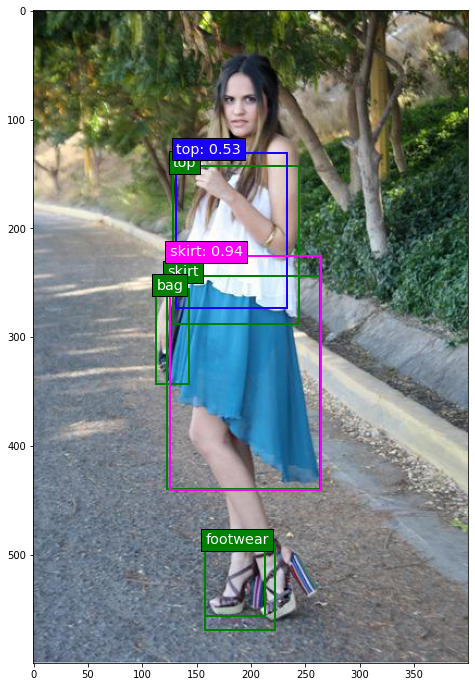

In [ ]:
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

classes = ['background','bag', 'belt', 'boots', 'footwear',
           'outer', 'dress', 'sunglasses', 'pants',
           'top', 'shorts', 'skirt', 'headwear',
           'scarf/tie']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})